In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    color = 'r'
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =0

nband = 180

ng =10

ng_refs = (/ 2 , 2 , 6 /) 

nref =3

nv = 200

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 360

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.7/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

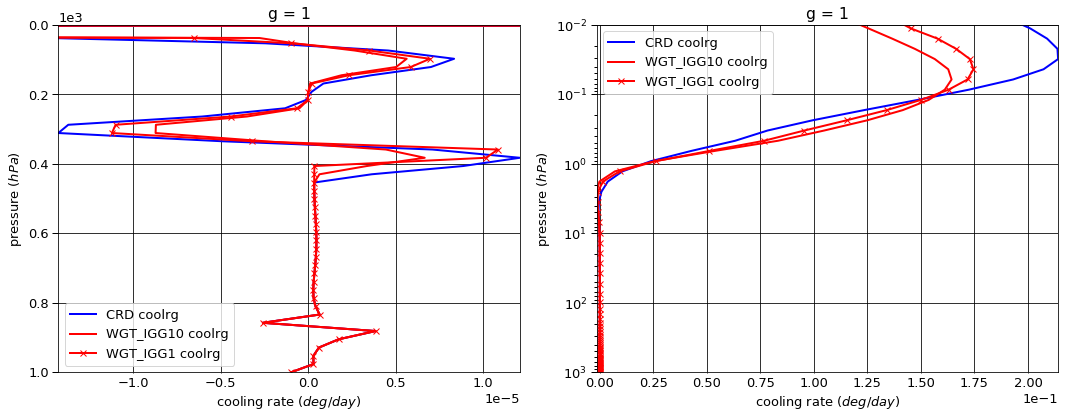

# Figure: cooling rate g-group 2

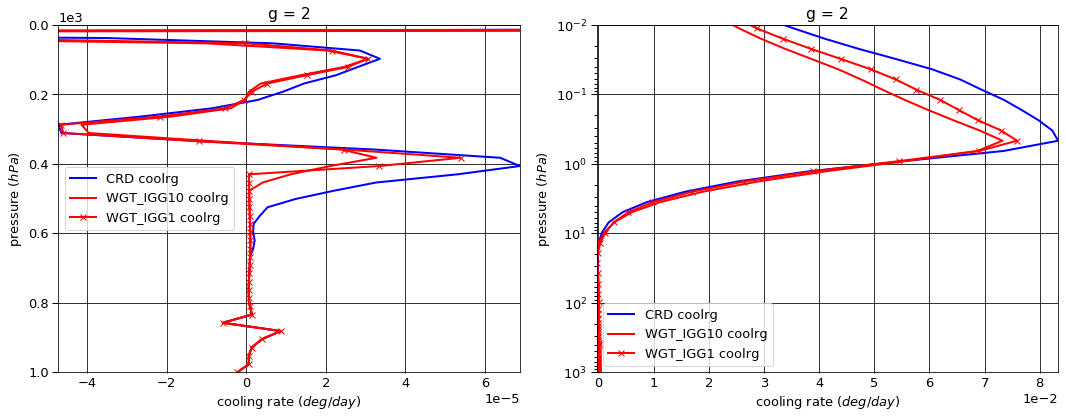

# Figure: cooling rate g-group 3

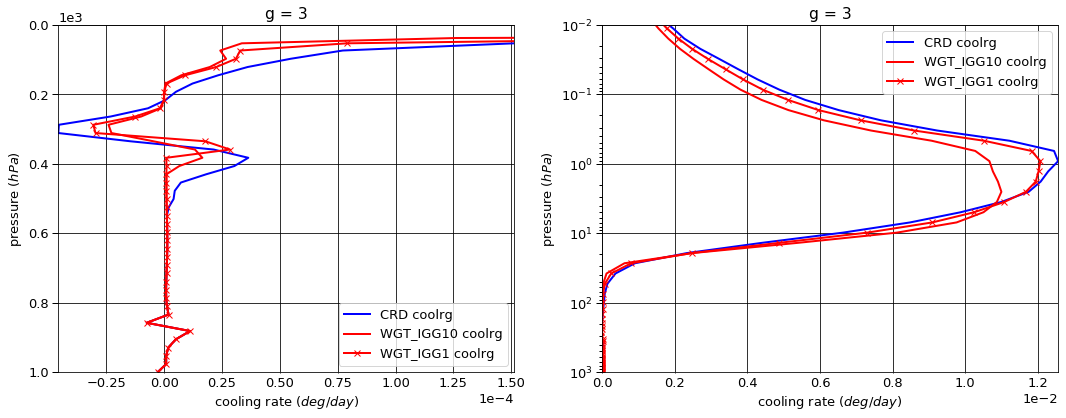

# Figure: cooling rate g-group 4

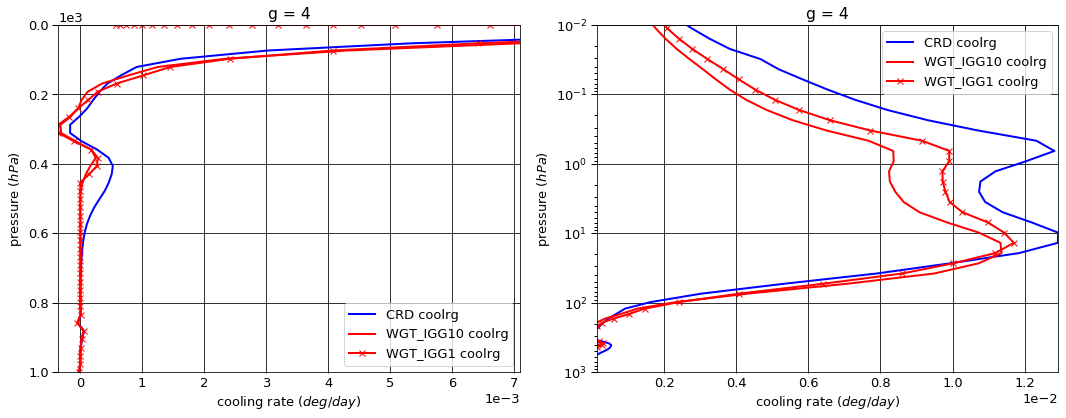

# Figure: cooling rate g-group 5

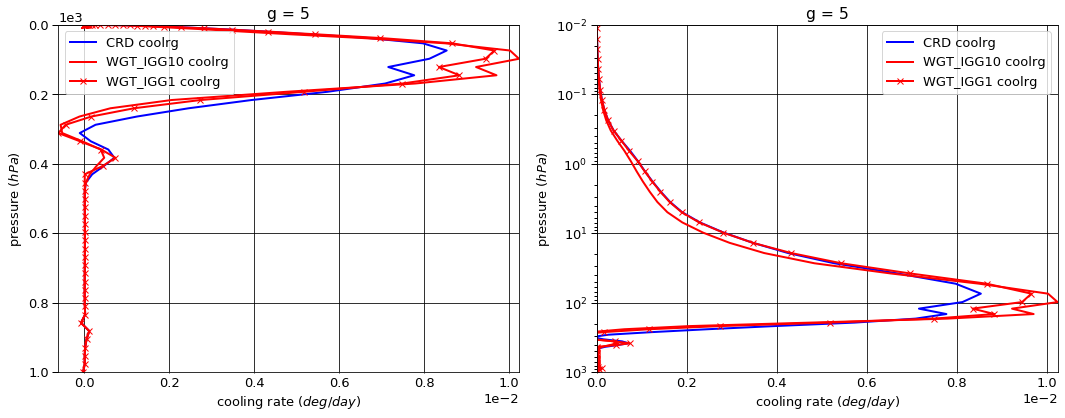

# Figure: cooling rate g-group 6

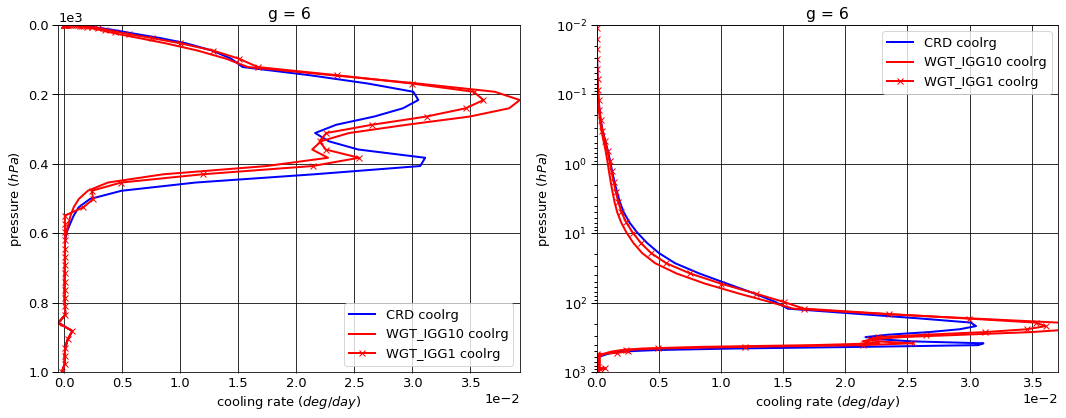

# Figure: cooling rate g-group 7

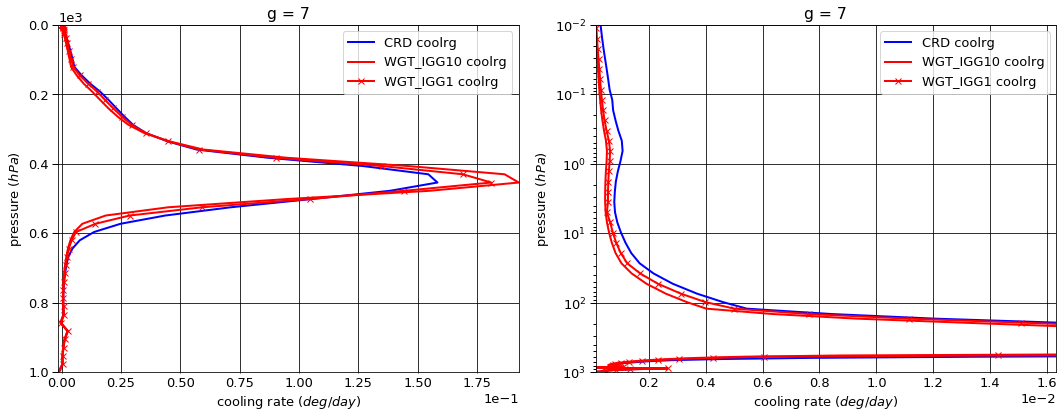

# Figure: cooling rate g-group 8

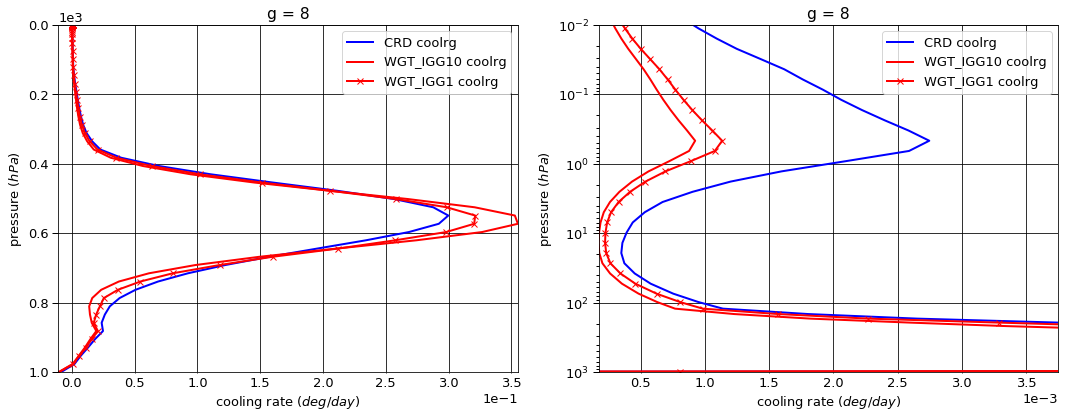

# Figure: cooling rate g-group 9

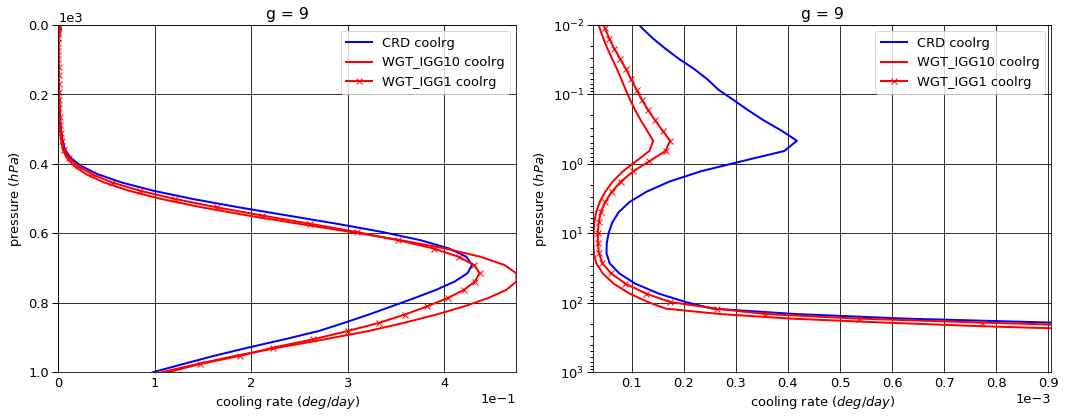

# Figure: cooling rate g-group 10

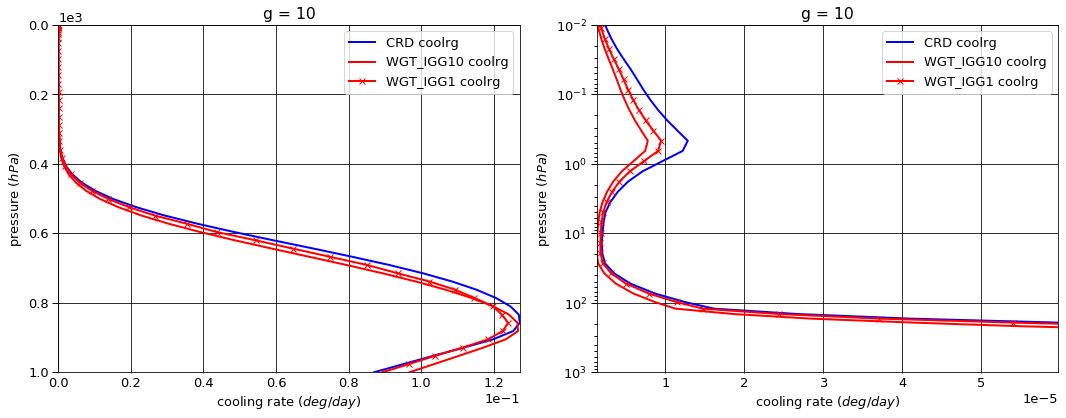

# Figure: cooling rate g-group total

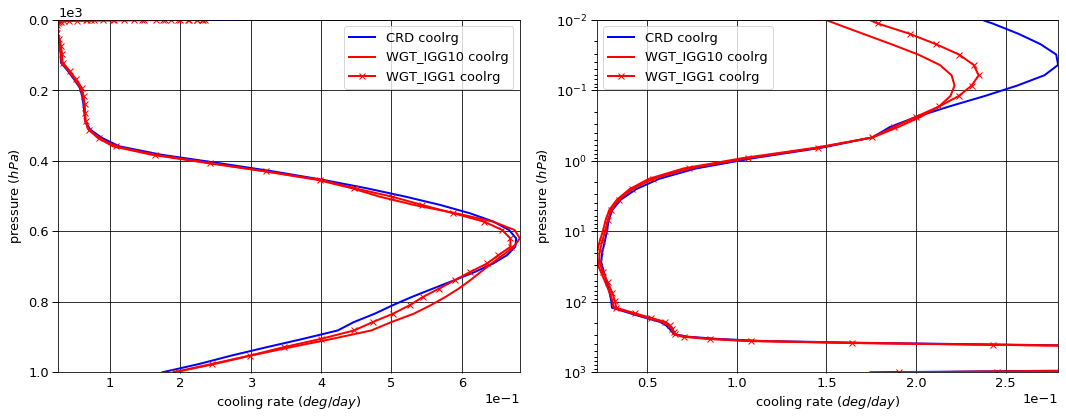

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.009262   0.000000  -0.009262
   1013.0   76     -0.010062   0.010065   0.000003
2  0.0      1      -0.017636   0.000000  -0.017636
   1013.0   76     -0.021928   0.021935   0.000008
3  0.0      1      -0.019029   0.000000  -0.019029
   1013.0   76     -0.028866   0.028875   0.000010
4  0.0      1      -0.096328   0.000000  -0.096328
   1013.0   76     -0.154710   0.154796   0.000086
5  0.0      1      -0.193968   0.000000  -0.193968
   1013.0   76     -0.308999   0.309100   0.000101
6  0.0      1      -1.192887   0.000000  -1.192887
   1013.0   76     -1.849986   1.850618   0.000632
7  0.0      1      -3.495333   0.000000  -3.495333
   1013.0   76     -4.765133   4.769440   0.004308
8  0.0      1      -8.904850   0.000000  -8.904850
   1013.0   76    -10.483674  10.539375   0.055701
9  0.0      1     -21.479321   0.000000 -21.479321
   1013.0   76    -22.732233  20.238910  -2.493323
10 0.0      1     -12.396408   0.000000 -12.396408
   1013.0   76    -12.565316   5.651807  -6.913509


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.009527   0.000000  -0.009527
   1013.0   76     -0.010062   0.010065   0.000003
2  0.0      1      -0.017474   0.000000  -0.017474
   1013.0   76     -0.021928   0.021935   0.000008
3  0.0      1      -0.018938   0.000000  -0.018938
   1013.0   76     -0.028866   0.028875   0.000010
4  0.0      1      -0.094122   0.000000  -0.094122
   1013.0   76     -0.154710   0.154762   0.000053
5  0.0      1      -0.193735   0.000000  -0.193735
   1013.0   76     -0.308999   0.309100   0.000101
6  0.0      1      -1.169799   0.000000  -1.169799
   1013.0   76     -1.849986   1.850618   0.000632
7  0.0      1      -3.473990   0.000000  -3.473990
   1013.0   76     -4.765133   4.768901   0.003768
8  0.0      1      -8.894015   0.000000  -8.894015
   1013.0   76    -10.483674  10.539949   0.056275
9  0.0      1     -21.625805   0.000000 -21.625805
   1013.0   76    -22.732233  21.239604  -1.492628
10 0.0      1     -12.432387   0.000000 -12.432387
   1013.0   76    -12.565316   5.352000  -7.213316


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.009456   0.000000  -0.009456
   1013.0   76     -0.010062   0.010065   0.000003
2  0.0      1      -0.017422   0.000000  -0.017422
   1013.0   76     -0.021928   0.021935   0.000008
3  0.0      1      -0.019015   0.000000  -0.019015
   1013.0   76     -0.028866   0.028875   0.000010
4  0.0      1      -0.094472   0.000000  -0.094472
   1013.0   76     -0.154710   0.154762   0.000053
5  0.0      1      -0.193677   0.000000  -0.193677
   1013.0   76     -0.308999   0.309100   0.000101
6  0.0      1      -1.175124   0.000000  -1.175124
   1013.0   76     -1.849986   1.850618   0.000632
7  0.0      1      -3.478164   0.000000  -3.478164
   1013.0   76     -4.765133   4.769929   0.004796
8  0.0      1      -8.899624   0.000000  -8.899624
   1013.0   76    -10.483674  10.544223   0.060549
9  0.0      1     -21.576574   0.000000 -21.576574
   1013.0   76    -22.732233  20.557377  -2.174856
10 0.0      1     -12.408718   0.000000 -12.408718
   1013.0   76    -12.565316   5.422156  -7.143160


WGT_IGG10 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1     -2.656218e-04  0.000000 -2.656218e-04
   1013.0   76     0.000000e+00  0.000000  4.235165e-22
2  0.0      1      1.621180e-04  0.000000  1.621180e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
3  0.0      1      9.092700e-05  0.000000  9.092700e-05
   1013.0   76     0.000000e+00  0.000000 -1.694066e-21
4  0.0      1      2.206798e-03  0.000000  2.206798e-03
   1013.0   76     0.000000e+00 -0.000033 -3.325634e-05
5  0.0      1      2.325500e-04  0.000000  2.325500e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
6  0.0      1      2.308770e-02  0.000000  2.308770e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      2.134310e-02  0.000000  2.134310e-02
   1013.0   76     0.000000e+00 -0.000539 -5.395250e-04
8  0.0      1      1.083510e-02  0.000000  1.083510e-02
   1013.0   76     0.000000e+00  0.000574  5.740190e-04
9  0.0      1     -1.464840e-01  0.000000 -1.464840e-01
   1013.0   76    -3.552714e-15  1.000694  1.000694e+00
10 0.0      1     -3.597900e-02  0.000000 -3.597900e-02
   1013.0   76     1.776357e-15 -0.299807 -2.998071e-01


WGT_IGG1 - CRD


flug      fldg         fnetg
g  pressure level                                      
1  0.0      1     -1.941701e-04  0.000000 -1.941701e-04
   1013.0   76     0.000000e+00  0.000000  4.235165e-22
2  0.0      1      2.139350e-04  0.000000  2.139350e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
3  0.0      1      1.420200e-05  0.000000  1.420200e-05
   1013.0   76     0.000000e+00  0.000000 -1.694066e-21
4  0.0      1      1.855971e-03  0.000000  1.855971e-03
   1013.0   76     0.000000e+00 -0.000033 -3.325634e-05
5  0.0      1      2.911800e-04  0.000000  2.911800e-04
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
6  0.0      1      1.776310e-02  0.000000  1.776310e-02
   1013.0   76     0.000000e+00  0.000000  0.000000e+00
7  0.0      1      1.716950e-02  0.000000  1.716950e-02
   1013.0   76     0.000000e+00  0.000488  4.880521e-04
8  0.0      1      5.226200e-03  0.000000  5.226200e-03
   1013.0   76     0.000000e+00  0.004848  4.847400e-03
9  0.0      1     -9.725300e-02  0.000000 -9.725300e-02
   1013.0   76    -3.552714e-15  0.318467  3.184669e-01
10 0.0      1     -1.231000e-02  0.000000 -1.231000e-02
   1013.0   76     1.776357e-15 -0.229651 -2.296507e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      8.763684e-02
   1001.112500 75    -9.815380e-07
2  0.000312    1      7.325787e-03
   1001.112500 75    -2.204976e-06
3  0.000312    1      3.834536e-04
   1001.112500 75    -2.849786e-06
4  0.000312    1      6.485693e-04
   1001.112500 75    -2.268897e-05
5  0.000312    1      7.209319e-08
   1001.112500 75    -2.945397e-05
6  0.000312    1      6.901703e-06
   1001.112500 75    -1.838221e-04
7  0.000312    1      1.092243e-04
   1001.112500 75    -1.194297e-03
8  0.000312    1      2.530931e-04
   1001.112500 75    -8.838985e-03
9  0.000312    1      2.469155e-05
   1001.112500 75     9.780904e-02
10 0.000312    1      1.804105e-07
   1001.112500 75     8.701426e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      3.935041e-02
   1001.112500 75    -9.815380e-07
2  0.000312    1      6.186572e-03
   1001.112500 75    -2.204976e-06
3  0.000312    1      3.629565e-04
   1001.112500 75    -2.849786e-06
4  0.000312    1      5.023053e-04
   1001.112500 75    -1.534071e-05
5  0.000312    1      5.965049e-08
   1001.112500 75    -2.945397e-05
6  0.000312    1      5.452430e-06
   1001.112500 75    -1.838221e-04
7  0.000312    1      4.508814e-05
   1001.112500 75    -1.073494e-03
8  0.000312    1      7.205357e-05
   1001.112500 75    -1.074740e-02
9  0.000312    1      6.745747e-06
   1001.112500 75     1.071821e-01
10 0.000312    1      1.080253e-07
   1001.112500 75     9.677684e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      5.250268e-02
   1001.112500 75    -9.815380e-07
2  0.000312    1      1.193330e-02
   1001.112500 75    -2.204976e-06
3  0.000312    1      4.026869e-04
   1001.112500 75    -2.849786e-06
4  0.000312    1      5.873859e-04
   1001.112500 75    -1.534071e-05
5  0.000312    1      7.187367e-08
   1001.112500 75    -2.945397e-05
6  0.000312    1      6.587675e-06
   1001.112500 75    -1.838221e-04
7  0.000312    1      5.505416e-05
   1001.112500 75    -1.343744e-03
8  0.000312    1      9.478452e-05
   1001.112500 75    -1.049599e-02
9  0.000312    1      9.402046e-06
   1001.112500 75     1.133909e-01
10 0.000312    1      1.572828e-07
   1001.112500 75     8.937076e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -4.828644e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.139215e-03
   1001.112500 75     0.000000e+00
3  0.000312    1     -2.049710e-05
   1001.112500 75     4.235165e-22
4  0.000312    1     -1.462640e-04
   1001.112500 75     7.348264e-06
5  0.000312    1     -1.244270e-08
   1001.112500 75     0.000000e+00
6  0.000312    1     -1.449273e-06
   1001.112500 75     0.000000e+00
7  0.000312    1     -6.413617e-05
   1001.112500 75     1.208036e-04
8  0.000312    1     -1.810396e-04
   1001.112500 75    -1.908418e-03
9  0.000312    1     -1.794580e-05
   1001.112500 75     9.373011e-03
10 0.000312    1     -7.238514e-08
   1001.112500 75     9.762586e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.513417e-02
   1001.112500 75     0.000000e+00
2  0.000312    1      4.607512e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      1.923332e-05
   1001.112500 75     4.235165e-22
4  0.000312    1     -6.118340e-05
   1001.112500 75     7.348264e-06
5  0.000312    1     -2.195240e-10
   1001.112500 75     0.000000e+00
6  0.000312    1     -3.140282e-07
   1001.112500 75     0.000000e+00
7  0.000312    1     -5.417015e-05
   1001.112500 75    -1.494462e-04
8  0.000312    1     -1.583086e-04
   1001.112500 75    -1.657008e-03
9  0.000312    1     -1.528950e-05
   1001.112500 75     1.558183e-02
10 0.000312    1     -2.312770e-08
   1001.112500 75     2.356505e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-47.805022,0.000000,-47.805022
1013.0,76,-52.920905,43.574922,-9.345983



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-47.929793,0.00000,-47.929793
1013.0,76,-52.920905,44.27581,-8.645094



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-47.872246,0.000000,-47.872246
1013.0,76,-52.920905,43.669041,-9.251864



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.247703e-01,0.000000,-0.124770
1013.0,76,7.105427e-15,0.700888,0.700889



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-6.722308e-02,0.000000,-0.067223
1013.0,76,7.105427e-15,0.094119,0.094118


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.096389
1001.112500,75,0.174548



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.046532
1001.112500,75,0.191903



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.065592
1001.112500,75,0.190687



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.049857
1001.112500,75,0.017355



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.030797
1001.112500,75,0.016139


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000194,0.000191
2,0.000417,0.000415
3,0.000556,0.000548
4,0.002972,0.002934
5,0.006028,0.005876
6,0.035472,0.035078
7,0.091500,0.090356
8,0.200694,0.198606
9,0.430083,0.429875


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.207420e-18
2,4.515983e-19
3,3.585786e-19
4,4.018118e-20
5,8.769537e-20
6,1.186674e-20
7,1.605781e-21
8,2.172908e-22
9,2.940331e-23


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.207420e-18,NaN,0.000194,0.000191,0.000194,0.000191,1.0
2,4.515983e-19,0.107334,0.000417,0.000415,0.000611,0.000606,1.0
3,3.585786e-19,0.794021,0.000556,0.000548,0.001167,0.001154,10.0
4,4.018118e-20,0.112057,0.002972,0.002934,0.004139,0.004088,10.0
5,8.769537e-20,2.182498,0.006028,0.005876,0.010167,0.009964,500.0
6,1.186674e-20,0.135318,0.035472,0.035078,0.045639,0.045042,500.0
7,1.605781e-21,0.135318,0.091500,0.090356,0.137139,0.135398,500.0
8,2.172908e-22,0.135318,0.200694,0.198606,0.337833,0.334004,500.0
9,2.940331e-23,0.135318,0.430083,0.429875,0.767917,0.763879,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g  pressure                                                        
1     1  0.000312     1.386401e-17  6.945943e-18   1.995987  8.271847e-04
      2  0.000312     5.587098e-19  3.489403e-19   1.601161  3.686184e-05
      3  0.000312     1.404577e-20  1.281122e-20   1.096365  1.133072e-06
      4  0.000312     4.163615e-21  2.474052e-21   1.682913  2.682472e-07
      5  0.000312     1.849633e-25  1.849631e-25   1.000001  1.575168e-11
      6  0.000312     3.142834e-24  2.905974e-24   1.081508  2.555445e-10
      7  0.000312     2.249987e-23  4.745224e-24   4.741583  1.008911e-09
      8  0.000312     2.930544e-23  1.096014e-24  26.738200  1.054277e-09
      9  0.000312     2.105614e-24  1.082633e-25  19.449002  7.725848e-11
      10 0.000312     7.595744e-26  1.487152e-26   5.107578  4.907979e-12
2     1  0.000750     1.397942e-17  7.008007e-18   1.994778  3.360398e-04
      2  0.000750     5.789993e-19  3.625586e-19   1.596982  1.540612e-05
      3  0.000750     1.481287e-20  1.347226e-20   1.099509  4.805165e-07
      4  0.000750     4.354556e-21  2.561779e-21   1.699817  1.124717e-07
      5  0.000750     4.524329e-25  4.524319e-25   1.000002  1.551923e-11
      6  0.000750     3.325470e-24  3.070671e-24   1.082978  1.088255e-10
      7  0.000750     2.305491e-23  4.873249e-24   4.730911  4.166264e-10
      8  0.000750     3.024607e-23  1.114424e-24  27.140537  4.379335e-10
      9  0.000750     2.161746e-24  1.105452e-25  19.555313  3.193582e-11
      10 0.000750     7.926326e-26  1.526269e-26   5.193268  2.060271e-12
3     1  0.001052     1.421199e-17  7.134374e-18   1.992044  4.793797e-04
      2  0.001052     6.223826e-19  3.914010e-19   1.590140  2.327256e-05
      3  0.001052     1.643867e-20  1.485583e-20   1.106546  7.450863e-07
      4  0.001052     4.764824e-21  2.741657e-21   1.737936  1.708148e-07
      5  0.001052     6.628946e-25  6.628926e-25   1.000003  3.188804e-11
      6  0.001052     3.643342e-24  3.349127e-24   1.087848  1.667687e-10
      7  0.001052     2.422280e-23  5.126877e-24   4.724669  6.140634e-10
      8  0.001052     3.225193e-23  1.151905e-24  27.998782  6.538298e-10
      9  0.001052     2.282876e-24  1.151579e-25  19.823881  4.725024e-11
      10 0.001052     8.647945e-26  1.604092e-26   5.391178  3.143516e-12
4     1  0.001476     1.444487e-17  7.263422e-18   1.988713  6.840296e-04
      2  0.001476     6.698832e-19  4.226480e-19   1.584967  3.519635e-05
      3  0.001476     1.826068e-20  1.638956e-20   1.114165  1.156561e-06
      4  0.001476     5.225115e-21  2.934497e-21   1.780583  2.598681e-07
      5  0.001476     9.717709e-25  9.717668e-25   1.000004  6.557995e-11
      6  0.001476     4.008094e-24  3.668619e-24   1.092535  2.567412e-10
      7  0.001476     2.548894e-23  5.389159e-24   4.729669  9.062630e-10
      8  0.001476     3.443935e-23  1.191991e-24  28.892305  9.779231e-10
      9  0.001476     2.417371e-24  1.199599e-25  20.151491  7.011199e-11
      10 0.001476     9.462849e-26  1.683820e-26   5.619868  4.811112e-12
5     1  0.002070     1.467474e-17  7.393398e-18   1.984844  9.754959e-04
      2  0.002070     7.212421e-19  4.560486e-19   1.581503  5.320736e-05
      3  0.002070     2.028014e-20  1.806984e-20   1.122320  1.794064e-06
      4  0.002070     5.735913e-21  3.138340e-21   1.827690  3.954039e-07
      5  0.002070     1.424490e-24  1.424481e-24   1.000006  1.348329e-10
      6  0.002070     4.427728e-24  4.037032e-24   1.096778  3.969128e-10
      7  0.002070     2.684893e-23  5.656034e-24   4.746953  1.337760e-09
      8  0.002070     3.679883e-23  1.234410e-24  29.810867  1.463364e-09
      9  0.002070     2.565361e-24  1.248664e-25  20.544843  1.042199e-10
      10 0.002070     1.037365e-25  1.765166e-26   5.876872  7.374580e-12
6     1  0.002904     1.490122e-17  7.524113e-18   1.980463  1.390807e-03
      2  0.002904     7.767406e-19  4.917058e-19   1.579686  8.042411e-05
      3  0.002904     2.252115e

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
